## Imports

In [1]:
from pyofss import Domain, System, Gaussian, Fibre, Filter, Splitter, FibrePlotter, Noise, OpenclFibre, OpenclProgramm, Amplifier2LevelModel
from pyofss import temporal_power, spectral_power, lambda_to_nu, nu_to_lambda, multi_plot, single_plot, labels
from pyofss.field import energy, max_peak_params, spectrum_width_params
import numpy as np
import matplotlib as mpl
import matplotlib
mpl.rcParams['agg.path.chunksize'] = 10000
import pylab as plt
import time

from pyofss.modules.nonlinearity import calculate_gamma
from pyofss.domain import lambda_to_omega
import os.path

import pyopencl as cl
from pynvml import *
import sys


%matplotlib inline

plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "DejaVu Sans"

## Check devices availible

In [2]:
platforms = cl.get_platforms() # get a list of platforms
devices = [] # create an empty list to store devices
for platform in platforms: # loop through each platform
    devices.extend(platform.get_devices()) # add the devices from each platform to the list
device_count = len(devices) # get the length of the list
print(devices[0].name)
print(devices[1].name)
print(device_count) # print the number of devices

NVIDIA GeForce RTX 4090
NVIDIA GeForce RTX 4090
2


In [3]:
!gpustat

/bin/bash: строка 1: gpustat: команда не найдена


## Clear GPU cach

In [4]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

## Helper-functions

In [5]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Directory: ", dir, " is created!")

def get_device_memory_info():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"device name {nvmlDeviceGetName(handle)}")
    print("Total memory: {} MiB".format(info.total >> 20))
    print("Free memory: {} MiB".format(info.free >> 20))
    print("Used memory: {} MiB".format(info.used >> 20))
    nvmlShutdown()

## Get GPU info

In [6]:
get_device_memory_info()
!nvidia-smi --query-gpu=memory.free --format=csv

device name NVIDIA GeForce RTX 4090
Total memory: 24564 MiB
Free memory: 6788 MiB
Used memory: 17775 MiB
memory.free [MiB]
6788 MiB
24208 MiB


## Define laser parameters: variate only pump power

In [7]:
F1 = lambda_to_nu(1040) - lambda_to_nu(1035)
F2 = (lambda_to_nu(1030) - lambda_to_nu(1035))
FW1 = (Domain.vacuum_light_speed/(1040**2))*4
FW2 = (Domain.vacuum_light_speed/(1030**2))*4
C1 = 0.4
C2 = 0.9
E1 = 9.15
E2 = 36.6
L3 = 0.8
L6 = 0.8
SSG = 10
G1 = calculate_gamma(2.7*(10**(-20)), 37.8, lambda_to_omega(1035))
G2 = calculate_gamma(2.7*(10**(-20)), 29, lambda_to_omega(1035))
N = 4.2
N_cycles = 2
Pp_0 = 10

Esat_1 = E1                     # 9.15nJ
Esat_2 = E2                   # 36.6nJ
La_1 = 2.5*1e-3                  # 2.5m
La_2 = 2.5*1e-3                  # 2.5m
Lp_1 = 0.8*1e-3                                 # 0.8m
Lp_2 = L3*1e-3                                 # 0.8m
Lp_3 = 0.8*1e-3                                 # 0.8m
Lp_4 = L6*1e-3                                 # 0.8m
Lr = La_1 + La_2 + Lp_1 + Lp_2 + Lp_3 + Lp_4
Tr = Lr * 1e12 / Domain.vacuum_light_speed # ps
gamma_passive = G1
gamma_active = G2
small_signal_gain = SSG

local_error = 0.000001
step_size = 0.0000001

useRaman = True
useAdaptive = False
use_Yb_model = True
use_noise = False
noise_scale = 0.0000001

Dir = "resultsMamyshev"

method_ocl = "cl_rk4ip"

In [8]:
useRamanName = ""
useAdaptiveName = ""
if useRaman:
    use_all = "hollenbeck"
    useRamanName = "rmn"
    print(f"use raman gain, use_all:", use_all)
else: 
    use_all = False
    useRamanName = "no_rmn"
    print(f"DO NOT use raman gain, use_all:", use_all)

if useAdaptive:
    method='ark4ip'
    useAdaptiveName = "as"
    print(f"use adaptive stepper method:", method)
else: 
    method='rk4ip'
    useAdaptiveName = "ss"
    print(f"DO NOT use adaptive stepper:", method)

if use_Yb_model:
    useYbModelName = "ybm"
    print(f"use Yb amplification model")
else: 
    useYbModelName = "sm"
    print(f"use simple amplification model")

if use_noise:
    useNoiseName = "ns"
    print(f"use noise at the end of each amplification fibre")
else: 
    useNoiseName = "no_ns"
    print(f"no noise in the model")

folder_name = f"{useRamanName}_{useYbModelName}_{useNoiseName}_{useAdaptiveName}_{F1:.2f}_F2_{F2:.2f}_FW1_{FW1:.2f}_FW2_{FW2:.2f}_C1_{C1:.2f}_C2_{C2:.2f}_E1_{E1:.2f}_E2_{E2:.2f}_L3_{L3:.2f}_L6_{L6:.2f}_SSG_{SSG:.2f}_N_{N:.2f}_Pp_{Pp_0:.2f}_G1_{G1:.2f}_G2_{G2:.2f}_Nc_{N_cycles}_LE_{local_error}_SS_{step_size}_NS_{noise_scale}"
RootDir = os.path.join(
    Dir, folder_name)
check_dir(RootDir)
graph_dir = os.path.join(RootDir, "graph")
check_dir(graph_dir)
print(f"the data is stored in {folder_name}")

use raman gain, use_all: hollenbeck
DO NOT use adaptive stepper: rk4ip
use Yb amplification model
no noise in the model
Directory:  resultsMamyshev/rmn_ybm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_4.20_Pp_10.00_G1_4.34_G2_5.65_Nc_2_LE_1e-06_SS_1e-07_NS_1e-07  is created!
Directory:  resultsMamyshev/rmn_ybm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_4.20_Pp_10.00_G1_4.34_G2_5.65_Nc_2_LE_1e-06_SS_1e-07_NS_1e-07/graph  is created!
the data is stored in rmn_ybm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_4.20_Pp_10.00_G1_4.34_G2_5.65_Nc_2_LE_1e-06_SS_1e-07_NS_1e-07


## Define domain and initial pulse parameters

In [9]:
peak_power = 50.
peak_width = 3.
peak_C = 100.

domain = Domain(samples_per_bit=2**15, bit_width=200.0,
                total_bits=1, centre_nu=lambda_to_nu(1035))

gaussian = Gaussian(name="initial_pulse", peak_power=peak_power,
                    width=peak_width, C=peak_C, using_fwhm=True)
A = gaussian.generate(domain.t)
E = energy(A, domain.t)

In [10]:
total_steps=int(La_1/step_size)
total_steps

25000

## OpenCl run:

### run the modeling process:

In [11]:
sys_ocl = System(domain, A, charact_dir=os.path.join(RootDir, f'cycle_current'))
use_Yb_model=True  
platform = cl.get_platforms()[0] # get the first platform
device = platform.get_devices(device_type=cl.device_type.GPU)[1] # get the first GPU device
cl_program = OpenclProgramm(fast_math=True, use_all='hollenbeck', dorf='double', ctx=cl.Context([device]))
cl_program.set_domain(domain)
for i in range(N_cycles):
    sys_ocl.add(Filter(name="filter_1",width_nu=(FW1), offset_nu=(F1),
                m=1, channel=0, using_fwhm=True, type_filt="reflected"))
    sys_ocl.add(OpenclFibre(name="1_passive_fibre", cl_programm=cl_program, length=Lp_1, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_1/step_size), traces=500, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys_ocl.add(OpenclFibre(name="2_active_fibre", cl_programm=cl_program, amplifier=Amplifier2LevelModel(Pp=Pp_0, N=N, Rr=1/Tr, prg=cl_program.prg, queue=cl_program.queue, ctx=cl_program.ctx), length=La_1, gamma=gamma_active, beta=np.array(
        [0, 0, 24.9]), total_steps=int(La_1/step_size), traces=500, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    if use_noise:
        sys.add(Noise(name="gaussian_noise", disp_factor=noise_scale))
    sys_ocl.add(OpenclFibre(name="3_passive_fibre", cl_programm=cl_program, length=Lp_2, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_2/step_size), traces=500, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys_ocl.add(Splitter(name="splitter_1", loss=C1))
    sys_ocl.add(Filter(name="filter_2", width_nu=(FW2), offset_nu=(F2),
                m=1, channel=0, using_fwhm=True, type_filt="reflected"))
    sys_ocl.add(OpenclFibre(name="4_passive_fibre", cl_programm=cl_program, length=Lp_3, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]),  total_steps=int(Lp_3/step_size), traces=50, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys_ocl.add(OpenclFibre(name="5_active_fibre", cl_programm=cl_program, amplifier=Amplifier2LevelModel(Pp=Pp_0, N=N, Rr=1/Tr, prg=cl_program.prg, queue=cl_program.queue, ctx=cl_program.ctx), length=La_2, gamma=gamma_active, beta=np.array(
        [0, 0, 24.9]), total_steps=int(La_2/step_size), traces=50, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    if use_noise:
        sys.add(Noise(name="gaussian_noise", disp_factor=noise_scale))
    sys_ocl.add(OpenclFibre(name="6_passive_fibre", cl_programm=cl_program, length=Lp_4, gamma=gamma_passive, beta=np.array(
        [0, 0, 22.2]), total_steps=int(Lp_4/step_size), traces=50, self_steepening=False, method=method_ocl, cycle=f'cycle{int(i)}', save_represent="complex"))
    sys_ocl.add(Splitter(name="splitter_2", loss=C2))  # use from sh script
    
start = time.time()
sys_ocl.run()
stop = time.time()

print("Run time with cl is {}".format(stop-start))

Directory:  resultsMamyshev/rmn_ybm_no_ns_ss_-1.39_F2_1.41_FW1_1.11_FW2_1.13_C1_0.40_C2_0.90_E1_9.15_E2_36.60_L3_0.80_L6_0.80_SSG_10.00_N_4.20_Pp_10.00_G1_4.34_G2_5.65_Nc_2_LE_1e-06_SS_1e-07_NS_1e-07/cycle_current  is created!
Using compiler optimisations suitable for Nvidia GPUs
Passive fibre modulation
Using general expression for nonlinearity
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
Using general expression for nonlinearity
Passive fibre modulation
Using general expression for nonlinearity
filter_1
1_pass

/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:294: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:364: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


3_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


splitter_1
filter_2
4_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


5_active_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:294: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:364: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


6_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


splitter_2
new characts are saved
filter_1
1_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


2_active_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:294: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:364: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


3_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


splitter_1
filter_2
4_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


5_active_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:294: RuntimeWarning: divide by zero encountered in divide
  self._Psat_s = (self.h_p * self.domain.nu * 1e12) / (
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/amplifier.py:364: RuntimeWarning: invalid value encountered in divide
  self._ratio_s = self.sigma12_s / (self.sigma12_s + self.sigma21_s)
/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


6_passive_fibre
device name NVIDIA GeForce RTX 4090
Used memory: 17775 MiB
reset


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


splitter_2
new characts are saved
Run time with cl is 552.2444672584534


/home/k.saraeva@g.nsu.ru/examples/pyofss/modules/storage.py:120: UserWarning: Directory is not empty
  warnings.warn("Directory is not empty")


### Initialise dataframes

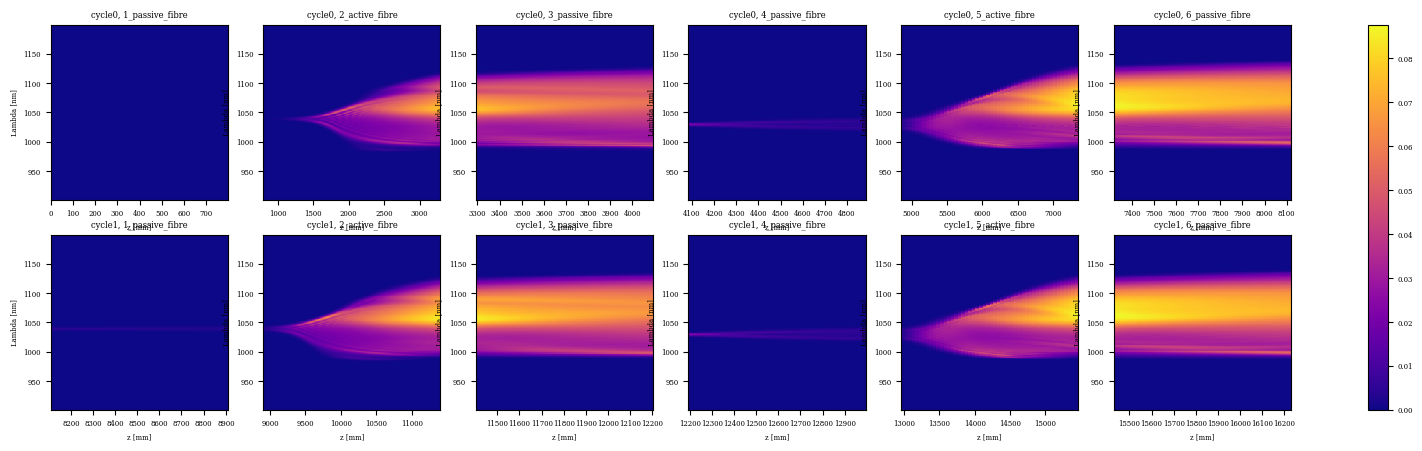

In [20]:
import pyofss.modules.fibre_plotter as plotter
from pyofss.field import get_downsampled

font = {"family": "serif", "weight": "normal", "size": 5}
matplotlib.rc("font", **font)

fig = plotter.visualise_fields_df(sys_ocl.df_spec, get_downsampled(domain.Lambda, downsampling=500), "Lambda [nm]", auto_lims=False, y_lims=(900, 1200))

In [21]:
sys_ocl.df_spec

0             1             2    \
cycle  fibre           z [mm]                                              
cycle0 1_passive_fibre 0.1      5.877472e-38  5.754988e-37  1.244522e-37   
                       1.7      4.995851e-36  6.302416e-36  3.347124e-37   
                       3.3      6.359424e-36  2.671668e-35  4.543570e-36   
                       4.9      1.468192e-35  2.885307e-35  3.714192e-36   
                       6.5      9.791868e-36  2.761991e-35  3.204856e-35   
...                                      ...           ...           ...   
cycle1 6_passive_fibre 16156.8  4.816751e-31  9.492275e-29  5.937629e-29   
                       16172.8  1.797714e-30  9.293961e-29  2.598249e-29   
                       16188.8  7.152182e-30  8.081583e-29  2.200729e-29   
                       16204.8  2.928819e-29  8.710056e-29  3.759949e-29   
                       16220.8  4.274031e-29  1.135619e-28  3.774558e-29   

                                         3             4             5    \
cycle  fibre           z [mm]                                              
cycle0 1_passive_fibre 0.1      1.503313e-36  8.305324e-37  4.449163e-37   
                       1.7      9.305770e-36  6.588934e-36  1.109058e-35   
                       3.3      6.576612e-35  2.081965e-35  3.492563e-35   
                       4.9      7.267231e-35  3.634766e-35  3.332625e-35   
                       6.5      1.805490e-35  4.456524e-35  3.079125e-35   
...                                      ...           ...           ...   
cycle1 6_passive_fibre 16156.8  3.360993e-29  1.264992e-30  7.131021e-29   
                       16172.8  3.690192e-29  1.023978e-30  4.776305e-29   
                       16188.8  2.849753e-29  1.735848e-30  5.925942e-29   
                       16204.8  2.413845e-29  7.099469e-30  6.979131e-29   
                       16220.8  2.737743e-29  1.012940e-29  7.356245e-29   

                                         6             7             8    \
cycle  fibre           z [mm]                                              
cycle0 1_passive_fibre 0.1      4.456526e-37  3.572007e-37  4.812982e-37   
                       1.7      9.836404e-36  2.980036e-35  7.082362e-36   
                       3.3      1.458435e-35  6.792188e-35  7.309652e-36   
                       4.9      3.196221e-35  1.028912e-35  2.015219e-35   
                       6.5      4.089836e-35  1.220031e-35  1.835847e-35   
...                                      ...           ...           ...   
cycle1 6_passive_fibre 16156.8  2.289000e-29  5.950842e-29  1.308057e-28   
                       16172.8  1.875390e-29  6.545062e-29  1.617168e-28   
                       16188.8  1.641156e-29  5.271122e-29  1.751369e-28   
                       16204.8  9.058372e-30  5.243573e-29  1.818151e-28   
                       16220.8  1.983491e-29  6.698850e-29  1.793863e-28   

                                         9    ...           490           491  \
cycle  fibre           z [mm]                 ...                               
cycle0 1_passive_fibre 0.1      1.092561e-37  ...  6.418317e-38  1.676478e-36   
                       1.7      3.292409e-36  ...  1.765625e-36  3.551161e-36   
                       3.3      1.055914e-35  ...  8.483691e-36  1.698256e-35   
                       4.9      1.288744e-35  ...  1.170413e-35  4.623092e-36   
                       6.5      1.003424e-35  ...  2.046591e-35  1.411019e-35   
...                                      ...  ...           ...           ...   
cycle1 6_passive_fibre 16156.8  7.403731e-29  ...  9.930176e-29  1.958877e-29   
                       16172.8  9.840848e-29  ...  1.098320e-28  1.972497e-29   
                       16188.8  1.128177e-28  ...  1.161160e-28  1.210680e-29   
                       16204.8  9.219300e-29  ...  1.144309e-28  1.609351e-29   
                       16220.8  6.538306e-29  ...  1.185615e-28  2.785070e-29   

                    

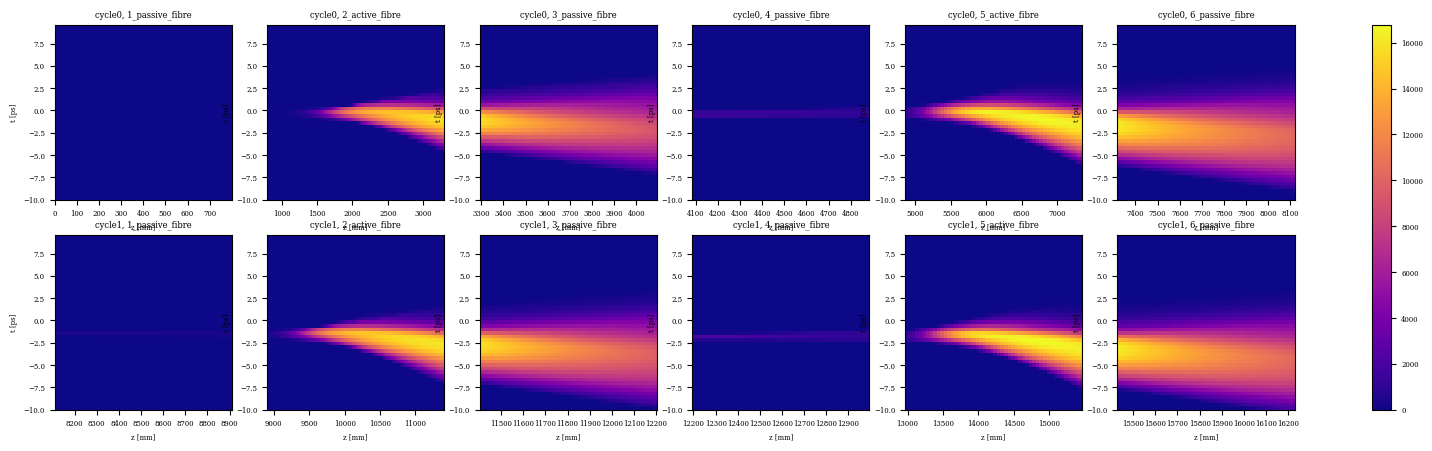

In [26]:
fig = plotter.visualise_fields_df(sys_ocl.df_temp, get_downsampled(domain.t, downsampling=500), "t [ps]", auto_lims=False, y_lims=(-10, 10))

Text(0, 0.5, 'Ld/Lnl')

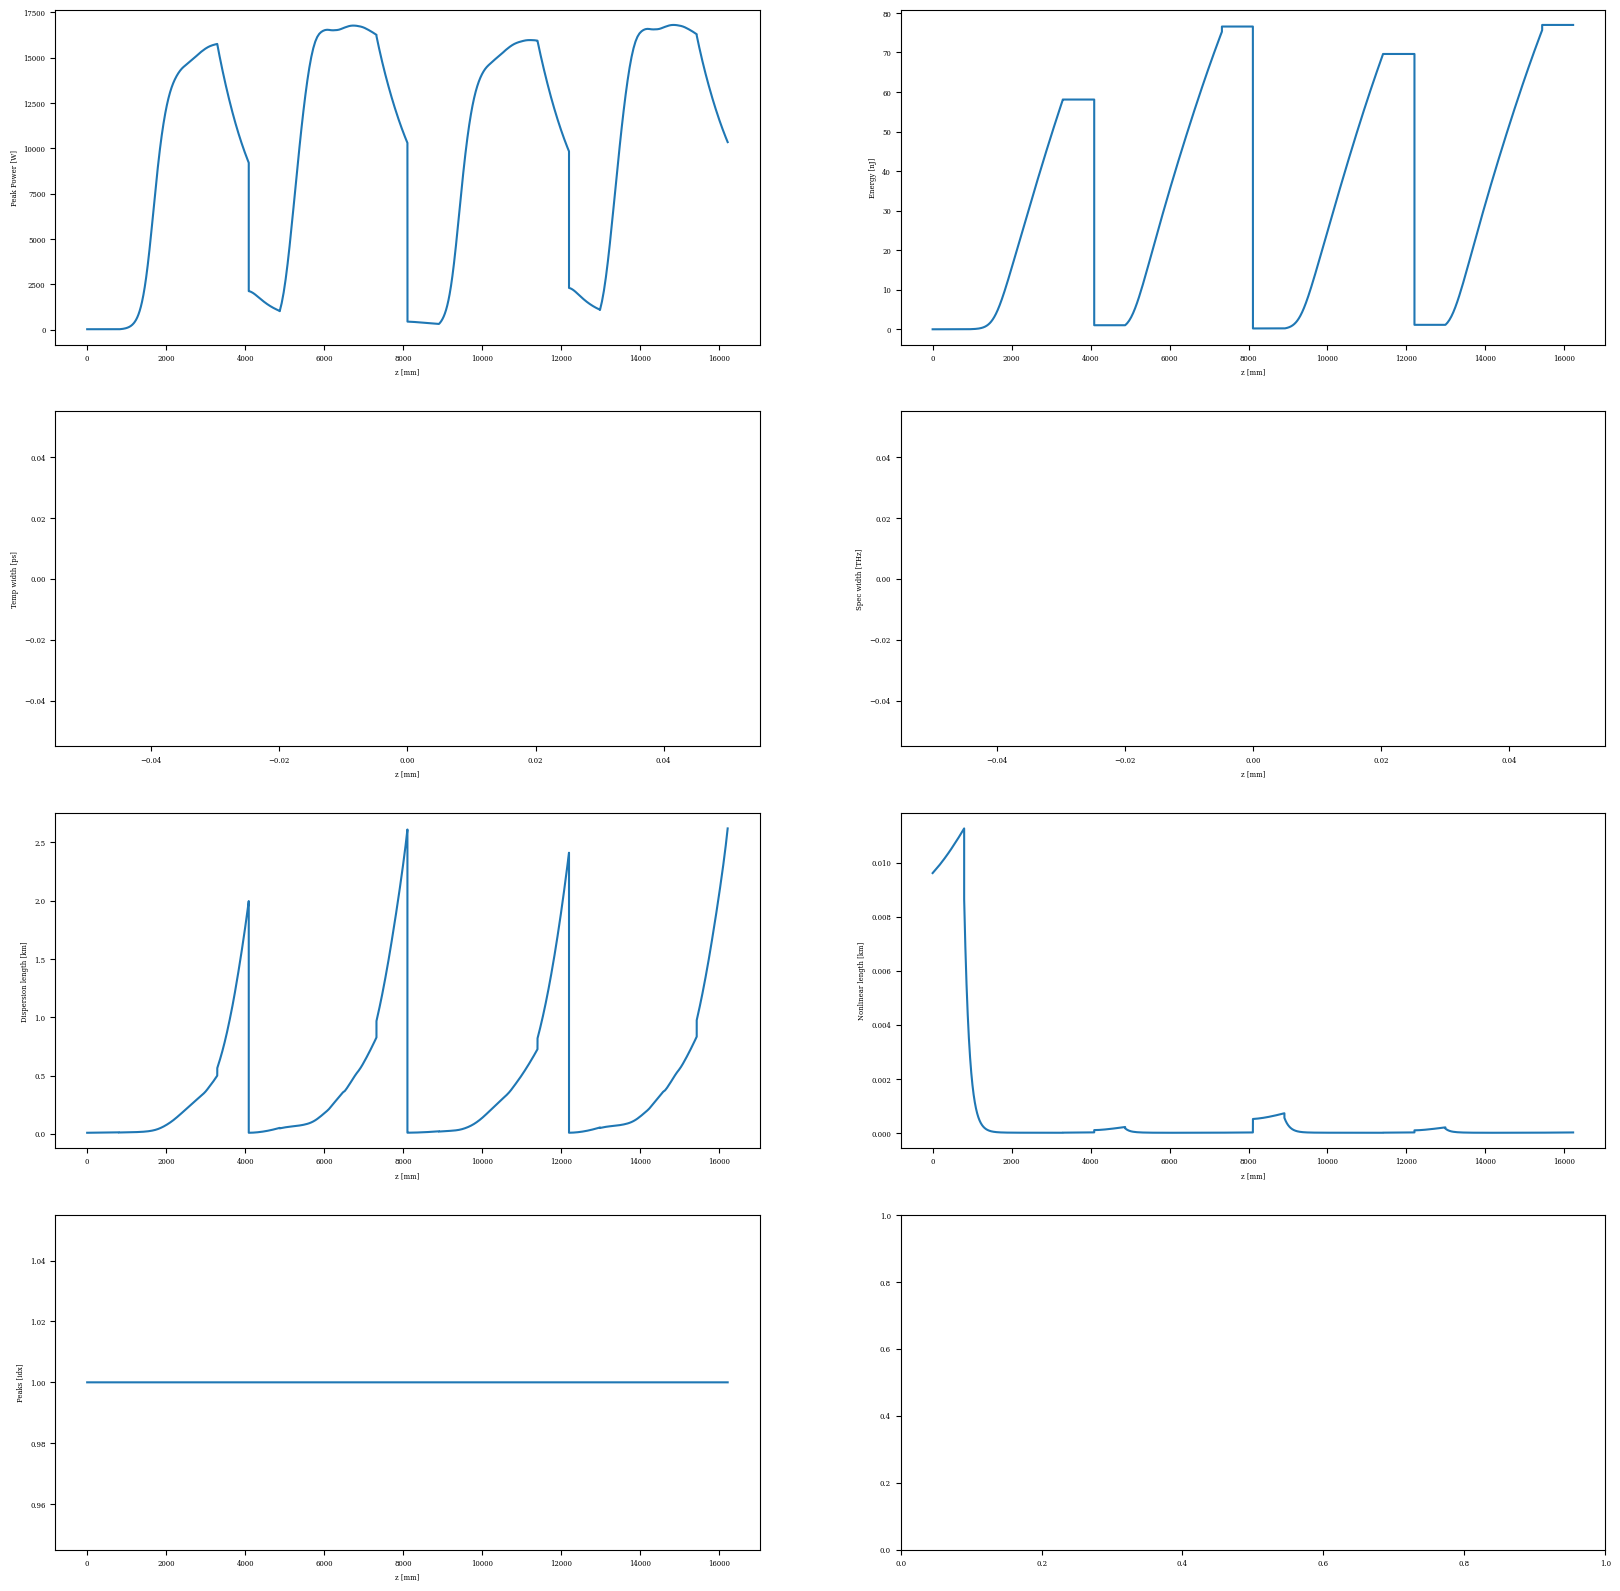

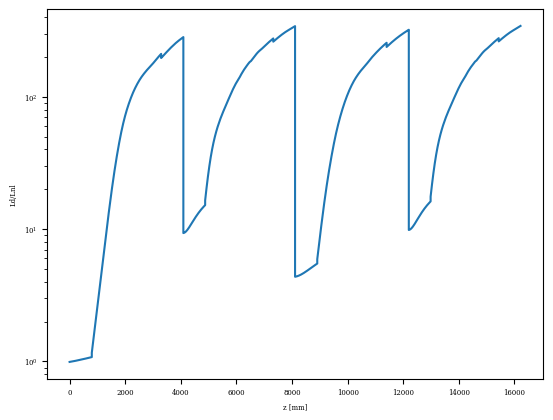

In [27]:
df_results = sys_ocl.df_results
plotter.visualise_results_df(df_results)

fig, ax = plt.subplots(1, 1)

N_arr = np.sqrt(df_results['Dispersion length [km]'].values/df_results['Nonlinear length [km]'].values)
z_arr = df_results.index.get_level_values("z [mm]").values
ax.plot(z_arr, N_arr)
ax.set_yscale("log")
ax.set_xlabel(f"z [mm]")
ax.set_ylabel(f"Ld/Lnl")

### Check the evolution of pulse characteristics

In [32]:
module_names = []
for module in sys_ocl.modules:    
    if (module.name in module_names):
        break
    else:
        module_names.append(module.name)

lines = []
lines.append(f"laser system 'Mamyshev Oscilator'")

for module_name in module_names:
    lines.append(f" --- {module_name} ---")

with open(os.path.join(graph_dir, "laser_structure.txt"), 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')